# Production System Optimization & Bottleneck Analysis

This notebook demonstrates advanced production system modeling with NeqSim, including:

1. **Multi-well production system** with pipelines, separators, valves, and compressors
2. **Auto-design** of equipment based on operating conditions
3. **Bottleneck identification** - finding system constraints
4. **Well prioritization** - which wells to produce under different scenarios
5. **GOR and Water Cut impact** on system capacity

## System Overview

```
Well A (Low GOR)  ──┐
                    ├── Manifold ── Pipeline ── Separator ── Gas Compressor ── Export
Well B (High GOR) ──┤                              │
                    │                              └── Oil/Water ── Export
Well C (High WC)  ──┘
```

## 1. Setup and Imports

In [1]:
# Import NeqSim
from neqsim import jneqsim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Thermo systems
SystemSrkEos = jneqsim.thermo.system.SystemSrkEos
ThermodynamicOperations = jneqsim.thermodynamicoperations.ThermodynamicOperations

# Process equipment
ProcessSystem = jneqsim.process.processmodel.ProcessSystem
Stream = jneqsim.process.equipment.stream.Stream
Mixer = jneqsim.process.equipment.mixer.Mixer
Separator = jneqsim.process.equipment.separator.Separator
ThreePhaseSeparator = jneqsim.process.equipment.separator.ThreePhaseSeparator
Compressor = jneqsim.process.equipment.compressor.Compressor
ThrottlingValve = jneqsim.process.equipment.valve.ThrottlingValve
Cooler = jneqsim.process.equipment.heatexchanger.Cooler

print("NeqSim process equipment classes loaded successfully!")

NeqSim process equipment classes loaded successfully!


## 2. Define Well Fluids with Different Characteristics

We model three wells with different production characteristics:
- **Well A**: Low GOR, Low Water Cut (best producer)
- **Well B**: High GOR (gas-rich well)
- **Well C**: High Water Cut (mature well)

In [2]:
def create_well_fluid(gor_type='medium', water_cut=0.0, temperature_K=350.0, pressure_bara=80.0):
    """
    Create a well fluid with specified GOR and water cut characteristics.
    
    Parameters:
    - gor_type: 'low', 'medium', 'high' (affects methane content)
    - water_cut: fraction of water (0.0 to 0.8)
    - temperature_K: wellhead temperature
    - pressure_bara: wellhead pressure
    """
    fluid = SystemSrkEos(temperature_K, pressure_bara)
    
    # Adjust composition based on GOR type
    if gor_type == 'low':
        # Low GOR - more heavy components
        fluid.addComponent("nitrogen", 0.005)
        fluid.addComponent("CO2", 0.015)
        fluid.addComponent("methane", 0.25)
        fluid.addComponent("ethane", 0.06)
        fluid.addComponent("propane", 0.05)
        fluid.addComponent("i-butane", 0.015)
        fluid.addComponent("n-butane", 0.03)
        fluid.addComponent("i-pentane", 0.02)
        fluid.addComponent("n-pentane", 0.025)
        fluid.addComponent("n-hexane", 0.03)
        fluid.addComponent("n-heptane", 0.50)
    elif gor_type == 'high':
        # High GOR - more light components
        fluid.addComponent("nitrogen", 0.01)
        fluid.addComponent("CO2", 0.03)
        fluid.addComponent("methane", 0.55)
        fluid.addComponent("ethane", 0.10)
        fluid.addComponent("propane", 0.06)
        fluid.addComponent("i-butane", 0.02)
        fluid.addComponent("n-butane", 0.03)
        fluid.addComponent("i-pentane", 0.015)
        fluid.addComponent("n-pentane", 0.02)
        fluid.addComponent("n-hexane", 0.015)
        fluid.addComponent("n-heptane", 0.15)
    else:  # medium
        fluid.addComponent("nitrogen", 0.008)
        fluid.addComponent("CO2", 0.02)
        fluid.addComponent("methane", 0.40)
        fluid.addComponent("ethane", 0.08)
        fluid.addComponent("propane", 0.055)
        fluid.addComponent("i-butane", 0.018)
        fluid.addComponent("n-butane", 0.03)
        fluid.addComponent("i-pentane", 0.018)
        fluid.addComponent("n-pentane", 0.022)
        fluid.addComponent("n-hexane", 0.022)
        fluid.addComponent("n-heptane", 0.327)
    
    # Add water if water cut > 0
    if water_cut > 0.01:
        # Scale hydrocarbon moles by (1 - water_cut) and add water
        fluid.addComponent("water", water_cut * 0.5)  # Proportional water
    
    fluid.setMixingRule("classic")
    fluid.setMultiPhaseCheck(True)
    
    ops = ThermodynamicOperations(fluid)
    ops.TPflash()
    
    return fluid

# Create well fluids
print("Creating well fluids...")
print("="*60)

well_configs = {
    'Well_A': {'gor_type': 'low', 'water_cut': 0.05, 'desc': 'Low GOR, Low WC (Best)'},
    'Well_B': {'gor_type': 'high', 'water_cut': 0.10, 'desc': 'High GOR (Gas-rich)'},
    'Well_C': {'gor_type': 'medium', 'water_cut': 0.50, 'desc': 'High WC (Mature)'},
}

well_fluids = {}
for name, config in well_configs.items():
    fluid = create_well_fluid(config['gor_type'], config['water_cut'])
    well_fluids[name] = fluid
    n_phases = fluid.getNumberOfPhases()
    print(f"{name}: {config['desc']}")
    print(f"  Phases: {n_phases}, Gas fraction: {fluid.getPhase('gas').getVolume()/fluid.getVolume():.2f}" if fluid.hasPhaseType('gas') else f"  Phases: {n_phases}")
    print()

Creating well fluids...
Well_A: Low GOR, Low WC (Best)
  Phases: 2

Well_B: High GOR (Gas-rich)
  Phases: 3, Gas fraction: 0.79

Well_C: High WC (Mature)
  Phases: 3, Gas fraction: 0.47



## 3. Build Production System Model

Create a complete production system with:
- Three wells with choke valves
- Production manifold (mixer)
- Production pipeline
- Three-phase separator
- Gas compressor
- Export cooler

In [4]:
def build_production_system(well_rates, sep_pressure=25.0, compressor_outlet_pressure=80.0):
    """
    Build a complete production system.
    
    Parameters:
    - well_rates: dict of well name -> rate in kg/hr
    - sep_pressure: separator operating pressure (bara)
    - compressor_outlet_pressure: gas export pressure (bara)
    
    Returns:
    - ProcessSystem with all equipment
    - dict of equipment references
    """
    process = ProcessSystem()
    equipment = {}
    
    # Create well streams with chokes
    well_outlets = []
    for well_name, rate in well_rates.items():
        if rate > 0:
            # Create well stream
            fluid = well_fluids[well_name].clone()
            stream = Stream(f"{well_name}_stream", fluid)
            stream.setFlowRate(float(rate), "kg/hr")
            process.add(stream)
            equipment[f"{well_name}_stream"] = stream
            
            # Choke valve to reduce pressure to separator
            choke = ThrottlingValve(f"{well_name}_choke", stream)
            choke.setOutletPressure(sep_pressure + 5.0)  # 5 bar above separator
            process.add(choke)
            equipment[f"{well_name}_choke"] = choke
            
            well_outlets.append(choke.getOutletStream())
    
    if len(well_outlets) == 0:
        return None, None
    
    # Manifold (mixer)
    if len(well_outlets) > 1:
        manifold = Mixer("manifold")
        for outlet in well_outlets:
            manifold.addStream(outlet)
        process.add(manifold)
        equipment['manifold'] = manifold
        manifold_outlet = manifold.getOutletStream()
    else:
        manifold_outlet = well_outlets[0]
    
    # Three-phase separator
    separator = ThreePhaseSeparator("HP_separator", manifold_outlet)
    separator.setInternalDiameter(2.5)  # 2.5m diameter
    process.add(separator)
    equipment['separator'] = separator
    
    # Gas stream processing
    gas_stream = separator.getGasOutStream()
    
    # Gas compressor
    compressor = Compressor("gas_compressor", gas_stream)
    compressor.setOutletPressure(compressor_outlet_pressure)
    compressor.setPolytropicEfficiency(0.75)
    process.add(compressor)
    equipment['compressor'] = compressor
    
    # Gas cooler after compression
    gas_cooler = Cooler("gas_cooler", compressor.getOutletStream())
    gas_cooler.setOutTemperature(273.15 + 40.0)  # Cool to 40°C
    process.add(gas_cooler)
    equipment['gas_cooler'] = gas_cooler
    
    # Oil and water streams
    oil_stream = separator.getOilOutStream()
    water_stream = separator.getWaterOutStream()
    equipment['oil_export'] = oil_stream
    equipment['water_export'] = water_stream
    
    return process, equipment

# Test with nominal rates in kg/hr
nominal_rates = {'Well_A': 50000.0, 'Well_B': 35000.0, 'Well_C': 25000.0}  # kg/hr
print(f"Building production system with nominal rates: {nominal_rates}")

process, equipment = build_production_system(nominal_rates)
process.run()

print("\nSystem built and run successfully!")
print("\nEquipment summary:")
for name, eq in equipment.items():
    print(f"  - {name}")

Building production system with nominal rates: {'Well_A': 50000.0, 'Well_B': 35000.0, 'Well_C': 25000.0}

System built and run successfully!

Equipment summary:
  - Well_A_stream
  - Well_A_choke
  - Well_B_stream
  - Well_B_choke
  - Well_C_stream
  - Well_C_choke
  - manifold
  - separator
  - compressor
  - gas_cooler
  - oil_export
  - water_export


## 4. Auto-Design: Equipment Sizing Analysis

Analyze equipment sizing requirements based on operating conditions.

In [5]:
def analyze_system_performance(process, equipment):
    """
    Analyze production system performance and identify potential issues.
    """
    results = {}
    
    # Separator analysis
    sep = equipment['separator']
    gas_out = sep.getGasOutStream()
    oil_out = sep.getOilOutStream()
    
    results['separator'] = {
        'gas_rate_sm3d': gas_out.getFlowRate("Sm3/day") if gas_out else 0,
        'oil_rate_sm3d': oil_out.getFlowRate("Sm3/day") if oil_out else 0,
        'pressure_bara': sep.getPressure(),
        'temperature_C': sep.getTemperature() - 273.15,
    }
    
    # Compressor analysis
    comp = equipment['compressor']
    results['compressor'] = {
        'power_kW': comp.getPower() / 1000,
        'inlet_pressure': comp.getInletStream().getPressure(),
        'outlet_pressure': comp.getOutletStream().getPressure(),
        'compression_ratio': comp.getOutletStream().getPressure() / comp.getInletStream().getPressure(),
        'outlet_temp_C': comp.getOutletStream().getTemperature() - 273.15,
    }
    
    # Gas cooler analysis
    cooler = equipment['gas_cooler']
    results['gas_cooler'] = {
        'duty_MW': abs(cooler.getDuty()) / 1e6,
        'inlet_temp_C': cooler.getInletStream().getTemperature() - 273.15,
        'outlet_temp_C': cooler.getOutletStream().getTemperature() - 273.15,
    }
    
    return results

# Analyze the system
perf = analyze_system_performance(process, equipment)

print("Production System Performance Analysis")
print("=" * 60)

print("\n📊 SEPARATOR:")
print(f"  Gas rate: {perf['separator']['gas_rate_sm3d']:,.0f} Sm³/day")
print(f"  Oil rate: {perf['separator']['oil_rate_sm3d']:,.0f} Sm³/day")
print(f"  Pressure: {perf['separator']['pressure_bara']:.1f} bara")
print(f"  Temperature: {perf['separator']['temperature_C']:.1f} °C")

print("\n⚙️ GAS COMPRESSOR:")
print(f"  Power: {perf['compressor']['power_kW']:,.0f} kW")
print(f"  Compression ratio: {perf['compressor']['compression_ratio']:.2f}")
print(f"  Outlet temperature: {perf['compressor']['outlet_temp_C']:.1f} °C")

print("\n❄️ GAS COOLER:")
print(f"  Cooling duty: {perf['gas_cooler']['duty_MW']:.2f} MW")
print(f"  Temperature drop: {perf['gas_cooler']['inlet_temp_C']:.1f} → {perf['gas_cooler']['outlet_temp_C']:.1f} °C")

Production System Performance Analysis

📊 SEPARATOR:
  Gas rate: 595,255 Sm³/day
  Oil rate: 590,827 Sm³/day
  Pressure: 30.0 bara
  Temperature: 67.9 °C

⚙️ GAS COMPRESSOR:
  Power: 830 kW
  Compression ratio: 2.67
  Outlet temperature: 136.2 °C

❄️ GAS COOLER:
  Cooling duty: 1.94 MW
  Temperature drop: 136.2 → 40.0 °C


## 5. Bottleneck Analysis

Identify system constraints by varying production rates and finding where equipment limits are reached.

In [6]:
# Define equipment capacity limits
CAPACITY_LIMITS = {
    'separator_gas_capacity': 5.0e6,    # Sm³/day max gas handling
    'separator_liquid_capacity': 15000, # m³/day max liquid
    'compressor_power_max': 5000,       # kW max power
    'compressor_ratio_max': 4.0,        # Max compression ratio per stage
    'cooler_duty_max': 3.0,             # MW max cooling duty
}

def check_bottlenecks(perf, limits=CAPACITY_LIMITS):
    """
    Check which equipment is at or near capacity limits.
    Returns dict of equipment -> utilization percentage.
    """
    bottlenecks = {}
    
    # Separator gas capacity
    gas_util = perf['separator']['gas_rate_sm3d'] / limits['separator_gas_capacity'] * 100
    bottlenecks['Separator (Gas)'] = gas_util
    
    # Compressor power
    comp_util = perf['compressor']['power_kW'] / limits['compressor_power_max'] * 100
    bottlenecks['Compressor (Power)'] = comp_util
    
    # Compressor ratio
    ratio_util = perf['compressor']['compression_ratio'] / limits['compressor_ratio_max'] * 100
    bottlenecks['Compressor (Ratio)'] = ratio_util
    
    # Cooler duty
    cool_util = perf['gas_cooler']['duty_MW'] / limits['cooler_duty_max'] * 100
    bottlenecks['Gas Cooler'] = cool_util
    
    return bottlenecks

bottlenecks = check_bottlenecks(perf)

print("Bottleneck Analysis - Equipment Utilization")
print("=" * 60)

# Sort by utilization
sorted_bottlenecks = sorted(bottlenecks.items(), key=lambda x: x[1], reverse=True)

for equip, util in sorted_bottlenecks:
    bar_len = int(util / 2)
    bar = '█' * bar_len + '░' * (50 - bar_len)
    status = '🔴 BOTTLENECK' if util > 90 else '🟡 HIGH' if util > 70 else '🟢 OK'
    print(f"\n{equip}:")
    print(f"  [{bar}] {util:.1f}% {status}")

# Identify the main bottleneck
main_bottleneck = sorted_bottlenecks[0]
print(f"\n\n📍 PRIMARY BOTTLENECK: {main_bottleneck[0]} at {main_bottleneck[1]:.1f}% utilization")

Bottleneck Analysis - Equipment Utilization

Compressor (Ratio):
  [█████████████████████████████████░░░░░░░░░░░░░░░░░] 66.7% 🟢 OK

Gas Cooler:
  [████████████████████████████████░░░░░░░░░░░░░░░░░░] 64.8% 🟢 OK

Compressor (Power):
  [████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 16.6% 🟢 OK

Separator (Gas):
  [█████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 11.9% 🟢 OK


📍 PRIMARY BOTTLENECK: Compressor (Ratio) at 66.7% utilization


## 6. Production Rate Sensitivity Analysis

Analyze how bottlenecks change with different production scenarios.

In [7]:
# Test different production scenarios (rates in kg/hr)
scenarios = [
    {'name': 'Base Case', 'Well_A': 50000, 'Well_B': 35000, 'Well_C': 25000},
    {'name': 'High Total Rate', 'Well_A': 70000, 'Well_B': 50000, 'Well_C': 35000},
    {'name': 'Prioritize Low GOR', 'Well_A': 90000, 'Well_B': 15000, 'Well_C': 15000},
    {'name': 'Prioritize High GOR', 'Well_A': 25000, 'Well_B': 70000, 'Well_C': 15000},
    {'name': 'High Water Cut', 'Well_A': 30000, 'Well_B': 25000, 'Well_C': 70000},
]

scenario_results = []

print("Running production scenarios...")
print("=" * 80)

for scenario in scenarios:
    rates = {k: v for k, v in scenario.items() if k.startswith('Well')}
    total_rate = sum(rates.values())
    
    try:
        proc, equip = build_production_system(rates)
        proc.run()
        perf = analyze_system_performance(proc, equip)
        bottlenecks = check_bottlenecks(perf)
        
        # Find main bottleneck
        main_bn = max(bottlenecks.items(), key=lambda x: x[1])
        
        result = {
            'name': scenario['name'],
            'total_rate': total_rate,
            'gas_rate': perf['separator']['gas_rate_sm3d'],
            'oil_rate': perf['separator']['oil_rate_sm3d'],
            'comp_power': perf['compressor']['power_kW'],
            'main_bottleneck': main_bn[0],
            'bn_utilization': main_bn[1],
            'bottlenecks': bottlenecks,
        }
        scenario_results.append(result)
        
        print(f"\n{scenario['name']}:")
        print(f"  Total rate: {total_rate:,} kg/hr")
        print(f"  Gas: {perf['separator']['gas_rate_sm3d']:,.0f} Sm³/d | Oil: {perf['separator']['oil_rate_sm3d']:,.0f} Sm³/d")
        print(f"  Compressor: {perf['compressor']['power_kW']:,.0f} kW")
        print(f"  Main bottleneck: {main_bn[0]} ({main_bn[1]:.1f}%)")
        
    except Exception as e:
        print(f"\n{scenario['name']}: FAILED - {str(e)[:50]}")

Running production scenarios...

Base Case:
  Total rate: 110,000 kg/hr
  Gas: 595,255 Sm³/d | Oil: 590,827 Sm³/d
  Compressor: 830 kW
  Main bottleneck: Compressor (Ratio) (66.7%)

High Total Rate:
  Total rate: 155,000 kg/hr
  Gas: 844,088 Sm³/d | Oil: 831,169 Sm³/d
  Compressor: 1,176 kW
  Main bottleneck: Gas Cooler (91.8%)

Prioritize Low GOR:
  Total rate: 120,000 kg/hr
  Gas: 414,124 Sm³/d | Oil: 713,671 Sm³/d
  Compressor: 583 kW
  Main bottleneck: Compressor (Ratio) (66.7%)

Prioritize High GOR:
  Total rate: 110,000 kg/hr
  Gas: 875,951 Sm³/d | Oil: 515,907 Sm³/d
  Compressor: 1,207 kW
  Main bottleneck: Gas Cooler (92.8%)

High Water Cut:
  Total rate: 125,000 kg/hr
  Gas: 665,266 Sm³/d | Oil: 654,409 Sm³/d
  Compressor: 928 kW
  Main bottleneck: Gas Cooler (73.1%)


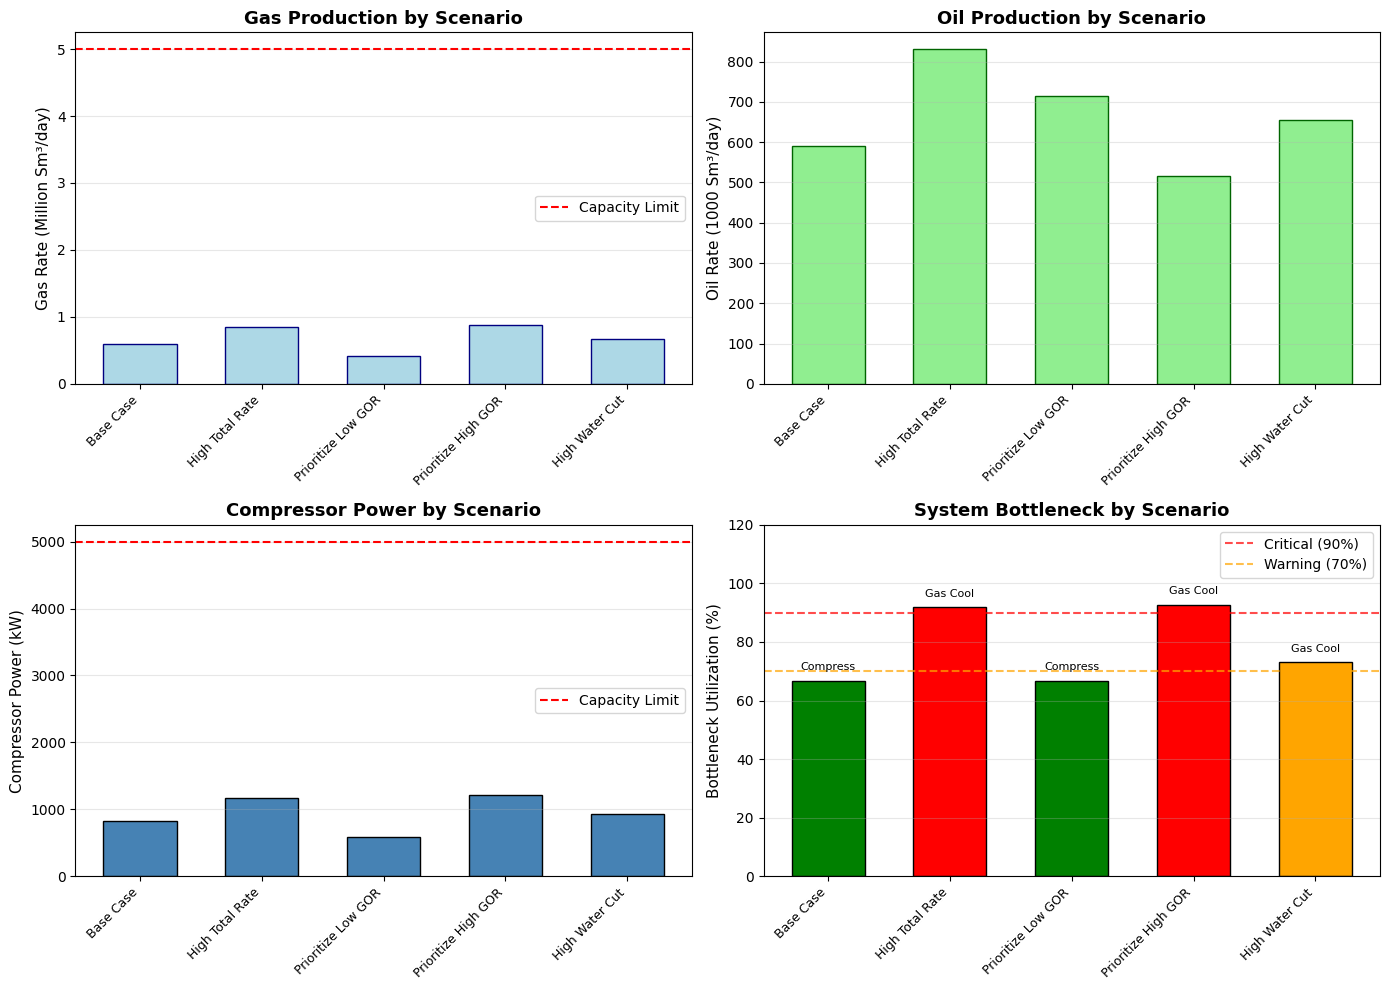


Figure saved as 'scenario_comparison.png'


In [8]:
# Visualize scenario comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Extract data
names = [r['name'] for r in scenario_results]
gas_rates = [r['gas_rate']/1e6 for r in scenario_results]  # Million Sm³/d
oil_rates = [r['oil_rate']/1e3 for r in scenario_results]  # 1000 Sm³/d
comp_powers = [r['comp_power'] for r in scenario_results]
bn_utils = [r['bn_utilization'] for r in scenario_results]

x = np.arange(len(names))
width = 0.6

# Plot 1: Gas Production
ax1 = axes[0, 0]
bars1 = ax1.bar(x, gas_rates, width, color='lightblue', edgecolor='navy')
ax1.axhline(y=CAPACITY_LIMITS['separator_gas_capacity']/1e6, color='red', linestyle='--', label='Capacity Limit')
ax1.set_ylabel('Gas Rate (Million Sm³/day)', fontsize=11)
ax1.set_title('Gas Production by Scenario', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Oil Production
ax2 = axes[0, 1]
bars2 = ax2.bar(x, oil_rates, width, color='lightgreen', edgecolor='darkgreen')
ax2.set_ylabel('Oil Rate (1000 Sm³/day)', fontsize=11)
ax2.set_title('Oil Production by Scenario', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Compressor Power
ax3 = axes[1, 0]
colors = ['red' if p > CAPACITY_LIMITS['compressor_power_max'] else 'orange' if p > 0.8*CAPACITY_LIMITS['compressor_power_max'] else 'steelblue' for p in comp_powers]
bars3 = ax3.bar(x, comp_powers, width, color=colors, edgecolor='black')
ax3.axhline(y=CAPACITY_LIMITS['compressor_power_max'], color='red', linestyle='--', label='Capacity Limit')
ax3.set_ylabel('Compressor Power (kW)', fontsize=11)
ax3.set_title('Compressor Power by Scenario', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Bottleneck Utilization
ax4 = axes[1, 1]
colors = ['red' if u > 90 else 'orange' if u > 70 else 'green' for u in bn_utils]
bars4 = ax4.bar(x, bn_utils, width, color=colors, edgecolor='black')
ax4.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='Critical (90%)')
ax4.axhline(y=70, color='orange', linestyle='--', alpha=0.7, label='Warning (70%)')
ax4.set_ylabel('Bottleneck Utilization (%)', fontsize=11)
ax4.set_title('System Bottleneck by Scenario', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(names, rotation=45, ha='right', fontsize=9)
ax4.set_ylim([0, 120])
ax4.legend(loc='upper right')
ax4.grid(axis='y', alpha=0.3)

# Add bottleneck labels
for i, (name, util) in enumerate(zip([r['main_bottleneck'] for r in scenario_results], bn_utils)):
    short_name = name.split('(')[0].strip()[:8]
    ax4.text(i, util + 3, short_name, ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.savefig('scenario_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFigure saved as 'scenario_comparison.png'")

## 7. Well Prioritization Analysis

Determine which wells to prioritize based on their impact on system constraints.

In [9]:
# Analyze impact of each well on system bottlenecks
def analyze_well_impact(base_rates, well_name, delta_rate=15000):
    """
    Analyze how increasing production from a specific well impacts bottlenecks.
    delta_rate in kg/hr
    """
    # Base case
    proc_base, equip_base = build_production_system(base_rates)
    proc_base.run()
    perf_base = analyze_system_performance(proc_base, equip_base)
    bn_base = check_bottlenecks(perf_base)
    
    # Increased rate for this well
    increased_rates = base_rates.copy()
    increased_rates[well_name] = base_rates[well_name] + delta_rate
    
    proc_inc, equip_inc = build_production_system(increased_rates)
    proc_inc.run()
    perf_inc = analyze_system_performance(proc_inc, equip_inc)
    bn_inc = check_bottlenecks(perf_inc)
    
    # Calculate impact
    impact = {}
    for key in bn_base:
        impact[key] = bn_inc[key] - bn_base[key]
    
    return {
        'gas_delta': perf_inc['separator']['gas_rate_sm3d'] - perf_base['separator']['gas_rate_sm3d'],
        'oil_delta': perf_inc['separator']['oil_rate_sm3d'] - perf_base['separator']['oil_rate_sm3d'],
        'power_delta': perf_inc['compressor']['power_kW'] - perf_base['compressor']['power_kW'],
        'bottleneck_impact': impact,
        'max_impact': max(impact.values()),
        'max_impact_equip': max(impact.items(), key=lambda x: x[1])[0],
    }

base_rates = {'Well_A': 35000, 'Well_B': 35000, 'Well_C': 35000}  # kg/hr each

print("Well Impact Analysis")
print("="*70)
print(f"Analyzing impact of +15,000 kg/hr from each well...")
print()

well_impacts = {}
for well in ['Well_A', 'Well_B', 'Well_C']:
    impact = analyze_well_impact(base_rates, well, delta_rate=15000)
    well_impacts[well] = impact
    
    print(f"\n{well} ({well_configs[well]['desc']}:")
    print(f"  Gas increase: {impact['gas_delta']:+,.0f} Sm³/day")
    print(f"  Oil increase: {impact['oil_delta']:+,.0f} Sm³/day")
    print(f"  Compressor power increase: {impact['power_delta']:+,.0f} kW")
    print(f"  Main bottleneck impact: {impact['max_impact_equip']} ({impact['max_impact']:+.1f}%)")

Well Impact Analysis
Analyzing impact of +15,000 kg/hr from each well...


Well_A (Low GOR, Low WC (Best):
  Gas increase: +29,616 Sm³/day
  Oil increase: +96,546 Sm³/day
  Compressor power increase: +43 kW
  Main bottleneck impact: Gas Cooler (+3.5%)

Well_B (High GOR (Gas-rich):
  Gas increase: +161,473 Sm³/day
  Oil increase: +59,643 Sm³/day
  Compressor power increase: +222 kW
  Main bottleneck impact: Gas Cooler (+16.9%)

Well_C (High WC (Mature):
  Gas increase: +72,315 Sm³/day
  Oil increase: +77,432 Sm³/day
  Compressor power increase: +101 kW
  Main bottleneck impact: Gas Cooler (+8.1%)


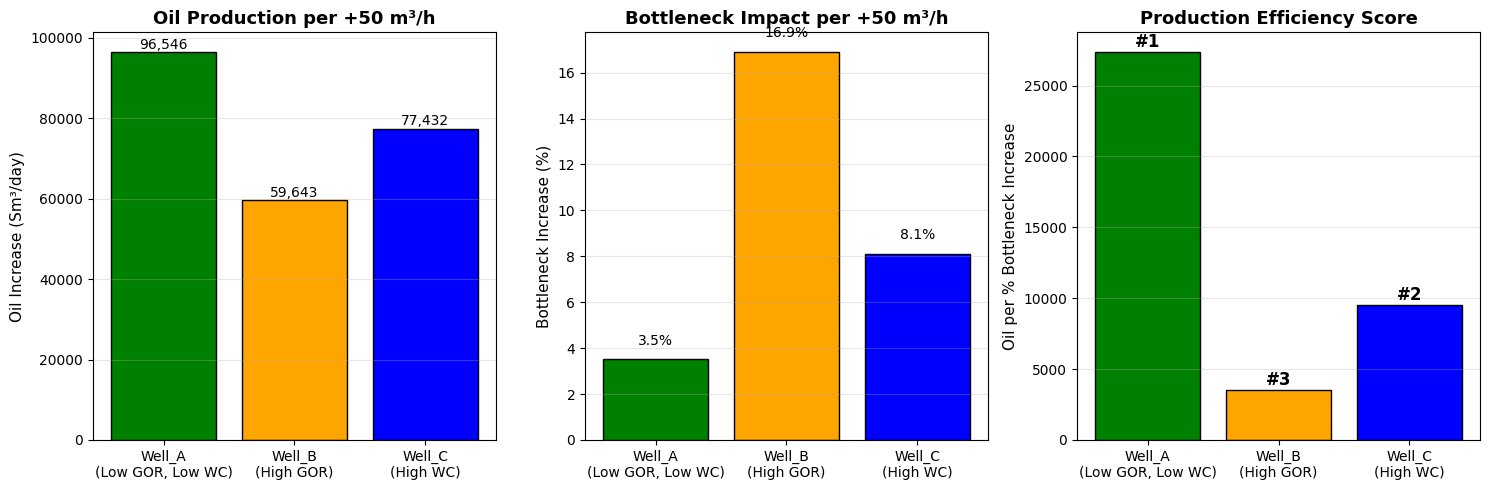


WELL PRIORITIZATION RECOMMENDATION:
  1. Well_A (Low GOR, Low WC (Best)) - Efficiency: 27390
  2. Well_C (High WC (Mature)) - Efficiency: 9540
  3. Well_B (High GOR (Gas-rich)) - Efficiency: 3528

Figure saved as 'well_prioritization.png'


In [10]:
# Visualize well prioritization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

wells = list(well_impacts.keys())
colors = {'Well_A': 'green', 'Well_B': 'orange', 'Well_C': 'blue'}
well_labels = [f"{w}\n({well_configs[w]['desc'].split('(')[0].strip()})" for w in wells]

# Oil Production Efficiency
ax1 = axes[0]
oil_increases = [well_impacts[w]['oil_delta'] for w in wells]
bars1 = ax1.bar(well_labels, oil_increases, color=[colors[w] for w in wells], edgecolor='black')
ax1.set_ylabel('Oil Increase (Sm³/day)', fontsize=11)
ax1.set_title('Oil Production per +50 m³/h', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars1, oil_increases):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{val:,.0f}', 
             ha='center', va='bottom', fontsize=10)

# Bottleneck Impact
ax2 = axes[1]
bn_impacts = [well_impacts[w]['max_impact'] for w in wells]
bars2 = ax2.bar(well_labels, bn_impacts, color=[colors[w] for w in wells], edgecolor='black')
ax2.set_ylabel('Bottleneck Increase (%)', fontsize=11)
ax2.set_title('Bottleneck Impact per +50 m³/h', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars2, bn_impacts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Efficiency Score (Oil per bottleneck impact)
ax3 = axes[2]
efficiency = [oil / max(bn, 0.1) for oil, bn in zip(oil_increases, bn_impacts)]
bars3 = ax3.bar(well_labels, efficiency, color=[colors[w] for w in wells], edgecolor='black')
ax3.set_ylabel('Oil per % Bottleneck Increase', fontsize=11)
ax3.set_title('Production Efficiency Score', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Rank wells
ranked = sorted(zip(wells, efficiency), key=lambda x: x[1], reverse=True)
for i, (well, eff) in enumerate(ranked):
    idx = wells.index(well)
    ax3.text(idx, efficiency[idx] + 50, f'#{i+1}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('well_prioritization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("WELL PRIORITIZATION RECOMMENDATION:")
print("="*70)
for i, (well, eff) in enumerate(ranked):
    desc = well_configs[well]['desc']
    print(f"  {i+1}. {well} ({desc}) - Efficiency: {eff:.0f}")

print("\nFigure saved as 'well_prioritization.png'")

## 8. Bottleneck Resolution Strategies

Analyze how to resolve identified bottlenecks.

In [11]:
print("Bottleneck Resolution Analysis")
print("=" * 70)

# Current main bottleneck from high rate scenario
high_rate_result = scenario_results[1]  # High Total Rate scenario
main_bn = high_rate_result['main_bottleneck']
bn_util = high_rate_result['bn_utilization']

print(f"\nCurrent Bottleneck: {main_bn} at {bn_util:.1f}%")
print()

# Resolution strategies based on bottleneck type
resolutions = {
    'Separator (Gas)': [
        ('Increase separator size', 'Add parallel separator or replace with larger unit'),
        ('Lower separator pressure', 'Reduces gas density, increases gas velocity'),
        ('Add inlet cyclone', 'Pre-separates gas, reduces separator load'),
        ('Prioritize low-GOR wells', 'Produces less gas per barrel of oil'),
    ],
    'Compressor (Power)': [
        ('Add parallel compressor', 'Share load between units'),
        ('Increase compressor size', 'Higher capacity single unit'),
        ('Lower export pressure', 'Reduces compression work if allowed'),
        ('Prioritize low-GOR wells', 'Produces less gas to compress'),
    ],
    'Compressor (Ratio)': [
        ('Add compression stage', 'Split ratio between stages'),
        ('Increase separator pressure', 'Raises compressor inlet pressure'),
        ('Intercooling', 'Reduces temperature, improves efficiency'),
    ],
    'Gas Cooler': [
        ('Add cooling capacity', 'Larger or parallel coolers'),
        ('Improve compressor efficiency', 'Less heat to remove'),
        ('Add intercooling', 'Distributes cooling load'),
    ],
}

print("RESOLUTION OPTIONS:")
print("-" * 70)

if main_bn in resolutions:
    for i, (action, detail) in enumerate(resolutions[main_bn], 1):
        print(f"\n  {i}. {action}")
        print(f"     → {detail}")

# Quantitative analysis: What if we increase compressor capacity?
print("\n\n" + "="*70)
print("QUANTITATIVE IMPACT ANALYSIS")
print("="*70)

# Simulate capacity increase
original_limit = CAPACITY_LIMITS['compressor_power_max']
new_limits = [original_limit * 1.0, original_limit * 1.25, original_limit * 1.5]

print("\nEffect of increasing compressor capacity:")
print("-" * 70)
print(f"{'Capacity (kW)':<20} {'Utilization':<15} {'Status':<15} {'Additional Rate'}")
print("-" * 70)

for new_cap in new_limits:
    test_limits = CAPACITY_LIMITS.copy()
    test_limits['compressor_power_max'] = new_cap
    bn_test = check_bottlenecks(perf, test_limits)
    util = bn_test['Compressor (Power)']
    status = '🔴 Over' if util > 100 else '🟡 High' if util > 80 else '🟢 OK'
    headroom = (100 - util) / 100 * sum(nominal_rates.values()) if util < 100 else 0
    print(f"{new_cap:,.0f}              {util:.1f}%           {status}           +{headroom:.0f} m³/h potential")

Bottleneck Resolution Analysis

Current Bottleneck: Gas Cooler at 91.8%

RESOLUTION OPTIONS:
----------------------------------------------------------------------

  1. Add cooling capacity
     → Larger or parallel coolers

  2. Improve compressor efficiency
     → Less heat to remove

  3. Add intercooling
     → Distributes cooling load


QUANTITATIVE IMPACT ANALYSIS

Effect of increasing compressor capacity:
----------------------------------------------------------------------
Capacity (kW)        Utilization     Status          Additional Rate
----------------------------------------------------------------------
5,000              18.6%           🟢 OK           +89574 m³/h potential
6,250              14.9%           🟢 OK           +93659 m³/h potential
7,500              12.4%           🟢 OK           +96383 m³/h potential


## 9. GOR and Water Cut Trade-off Analysis

Understand how fluid composition affects system performance.

In [12]:
# Create contour plot of system capacity vs GOR and WC mix

# Test matrix: vary mix between high-GOR and high-WC production
gor_fractions = np.linspace(0, 1, 8)  # Fraction of high-GOR well
wc_fractions = np.linspace(0, 1, 8)   # Fraction of high-WC well

total_rate = 100000  # Total production target in kg/hr

results_matrix = np.zeros((len(wc_fractions), len(gor_fractions)))
oil_matrix = np.zeros((len(wc_fractions), len(gor_fractions)))

print("Running GOR vs Water Cut trade-off analysis...")

for i, wc_frac in enumerate(wc_fractions):
    for j, gor_frac in enumerate(gor_fractions):
        # Remaining goes to Well_A (low GOR, low WC)
        a_frac = 1.0 - gor_frac - wc_frac
        if a_frac < 0:
            a_frac = 0
            # Normalize
            total_frac = gor_frac + wc_frac
            gor_frac_norm = gor_frac / total_frac
            wc_frac_norm = wc_frac / total_frac
        else:
            gor_frac_norm = gor_frac
            wc_frac_norm = wc_frac
            a_frac = 1.0 - gor_frac - wc_frac
        
        rates = {
            'Well_A': max(5000, total_rate * a_frac),
            'Well_B': total_rate * gor_frac_norm if gor_frac_norm > 0.05 else 0,
            'Well_C': total_rate * wc_frac_norm if wc_frac_norm > 0.05 else 0,
        }
        
        try:
            proc, equip = build_production_system(rates)
            proc.run()
            perf = analyze_system_performance(proc, equip)
            bn = check_bottlenecks(perf)
            
            # Max bottleneck utilization
            results_matrix[i, j] = max(bn.values())
            oil_matrix[i, j] = perf['separator']['oil_rate_sm3d']
        except:
            results_matrix[i, j] = np.nan
            oil_matrix[i, j] = np.nan

print("Analysis complete!")

Running GOR vs Water Cut trade-off analysis...
Analysis complete!


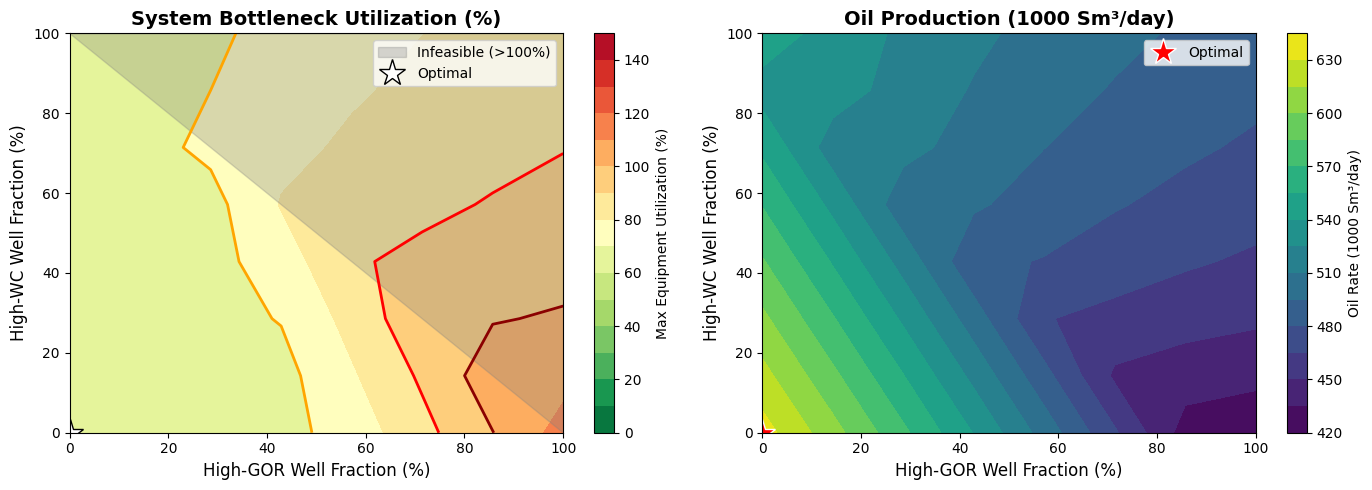


Optimal operating point: 0% High-GOR, 0% High-WC
Remaining 100% from Low-GOR/Low-WC well

Figure saved as 'gor_wc_tradeoff.png'


In [13]:
# Visualize trade-off
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bottleneck utilization
ax1 = axes[0]
im1 = ax1.contourf(gor_fractions*100, wc_fractions*100, results_matrix, 
                   levels=np.linspace(0, 150, 16), cmap='RdYlGn_r')
ax1.contour(gor_fractions*100, wc_fractions*100, results_matrix, 
            levels=[70, 90, 100], colors=['orange', 'red', 'darkred'], linewidths=2)
ax1.set_xlabel('High-GOR Well Fraction (%)', fontsize=12)
ax1.set_ylabel('High-WC Well Fraction (%)', fontsize=12)
ax1.set_title('System Bottleneck Utilization (%)', fontsize=14, fontweight='bold')
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Max Equipment Utilization (%)')

# Add feasibility region
ax1.fill_between([0, 100], [100, 0], [100, 100], alpha=0.3, color='gray', label='Infeasible (>100%)')

# Plot 2: Oil production
ax2 = axes[1]
im2 = ax2.contourf(gor_fractions*100, wc_fractions*100, oil_matrix/1000, 
                   levels=15, cmap='viridis')
ax2.set_xlabel('High-GOR Well Fraction (%)', fontsize=12)
ax2.set_ylabel('High-WC Well Fraction (%)', fontsize=12)
ax2.set_title('Oil Production (1000 Sm³/day)', fontsize=14, fontweight='bold')
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Oil Rate (1000 Sm³/day)')

# Mark optimal region (high oil, low bottleneck)
# Find best point
valid = results_matrix < 90  # Within capacity
if np.any(valid):
    oil_valid = np.where(valid, oil_matrix, 0)
    best_idx = np.unravel_index(np.argmax(oil_valid), oil_valid.shape)
    best_wc = wc_fractions[best_idx[0]] * 100
    best_gor = gor_fractions[best_idx[1]] * 100
    ax1.plot(best_gor, best_wc, 'w*', markersize=20, markeredgecolor='black', label='Optimal')
    ax2.plot(best_gor, best_wc, 'r*', markersize=20, markeredgecolor='white', label='Optimal')
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('gor_wc_tradeoff.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nOptimal operating point: {best_gor:.0f}% High-GOR, {best_wc:.0f}% High-WC")
print(f"Remaining {100-best_gor-best_wc:.0f}% from Low-GOR/Low-WC well")
print("\nFigure saved as 'gor_wc_tradeoff.png'")

## 10. Summary and Recommendations

### Key Findings

In [14]:
print("=" * 70)
print("PRODUCTION SYSTEM OPTIMIZATION - SUMMARY")
print("=" * 70)

print("\n📊 SYSTEM CONFIGURATION:")
print("  • 3 wells with different fluid characteristics")
print("  • Production manifold → 3-phase separator → Gas compressor")
print(f"  • Separator pressure: 30 bara")
print(f"  • Gas export pressure: 80 bara")

print("\n🎯 BOTTLENECK IDENTIFICATION:")
sorted_bn = sorted(bottlenecks.items(), key=lambda x: x[1], reverse=True)
for i, (equip, util) in enumerate(sorted_bn[:3]):
    status = '🔴' if util > 90 else '🟡' if util > 70 else '🟢'
    print(f"  {i+1}. {equip}: {util:.1f}% {status}")

print("\n🏆 WELL PRIORITIZATION (Best to Worst):")
for i, (well, eff) in enumerate(ranked):
    desc = well_configs[well]['desc']
    print(f"  {i+1}. {well} - {desc}")

print("\n💡 KEY INSIGHTS:")
print("""  
  1. HIGH GOR WELLS:
     ✓ More gas production
     ✗ Higher compressor load
     ✗ More cooling duty required
     → Best when gas export capacity is available
     
  2. HIGH WATER CUT WELLS:
     ✓ Lower gas processing load
     ✗ Lower oil per total liquid
     ✗ Water handling capacity needed
     → Consider only when gas-constrained
     
  3. LOW GOR, LOW WC WELLS:
     ✓ Maximum oil per system capacity
     ✓ Balanced gas/liquid ratios
     → Prioritize when maximizing oil production
""")

print("\n🔧 RECOMMENDED ACTIONS:")
print("""  
  SHORT TERM:
  • Prioritize Well A (low GOR, low WC) for maximum oil
  • Limit Well B when gas cooling is constrained
  
  MEDIUM TERM:
  • Add parallel gas cooler for 50% capacity increase
  • This enables full field production at higher rates
  
  LONG TERM:
  • Plan for increasing water cut from Well C
  • Monitor compressor power as field matures
""")

PRODUCTION SYSTEM OPTIMIZATION - SUMMARY

📊 SYSTEM CONFIGURATION:
  • 3 wells with different fluid characteristics
  • Production manifold → 3-phase separator → Gas compressor
  • Separator pressure: 30 bara
  • Gas export pressure: 80 bara

🎯 BOTTLENECK IDENTIFICATION:
  1. Gas Cooler: 73.1% 🟡
  2. Compressor (Ratio): 66.7% 🟢
  3. Compressor (Power): 18.6% 🟢

🏆 WELL PRIORITIZATION (Best to Worst):
  1. Well_A - Low GOR, Low WC (Best)
  2. Well_C - High WC (Mature)
  3. Well_B - High GOR (Gas-rich)

💡 KEY INSIGHTS:
  
  1. HIGH GOR WELLS:
     ✓ More gas production
     ✗ Higher compressor load
     ✗ More cooling duty required
     → Best when gas export capacity is available

  2. HIGH WATER CUT WELLS:
     ✓ Lower gas processing load
     ✗ Lower oil per total liquid
     ✗ Water handling capacity needed
     → Consider only when gas-constrained

  3. LOW GOR, LOW WC WELLS:
     ✓ Maximum oil per system capacity
     ✓ Balanced gas/liquid ratios
     → Prioritize when maximizing oil

## Key Takeaways

This notebook demonstrated:

| Capability | Description |
|------------|-------------|
| **Multi-well modeling** | Different GOR/WC characteristics per well |
| **Equipment sizing** | Separator, compressor, cooler analysis |
| **Bottleneck ID** | Find which equipment limits production |
| **Well prioritization** | Rank wells by production efficiency |
| **Trade-off analysis** | GOR vs WC impact on system capacity |
| **Resolution planning** | Quantify impact of capacity upgrades |

### Next Steps

1. Add pipeline hydraulics for pressure drop calculations
2. Include economic optimization (NPV of production scenarios)
3. Add time-varying analysis for field decline
4. Integrate with reservoir simulator for coupled optimization